# Regression with news (only one stock included)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
import numpy as np
import pandas as pd
import os
import copy
import sklearn
import xgboost
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from pythainlp.corpus import stopwords
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
from sklearn import tree, ensemble

% matplotlib inline

target_stocks = ['BANPU','IRPC','PTT','BBL','KBANK','SCB','AOT','THAI','CPF','MINT',
                 'TU','SCC','CPN','CK','CPALL','HMPRO','BDMS','BH','ADVANC','JAS','TRUE']

In [3]:
df_price = pd.read_csv('merged_2013_2018.csv')
df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
df_price = df_price.loc[df_price['Ticker'].isin(target_stocks)]
df_price['Date'] = df_price['Date'].dt.date
df_price = df_price.set_index('Date')
df_price.tail(3)
len(df_price)

df_kaohoon = pd.read_csv('data/kaohoon.csv')
df_kaohoon['Date'] = pd.to_datetime(df_kaohoon['Date'], format='%Y-%m-%d')
df_kaohoon = df_kaohoon.set_index('Date')
df_kaohoon = df_kaohoon[:'2018-2-8']
df_kaohoon.index = df_kaohoon.index.date
df_kaohoon.tail(3)
len(df_kaohoon)

df_moneych = pd.read_csv('data/moneychanel.csv')
df_moneych['Date'] = pd.to_datetime(df_moneych['Date'], format='%Y-%m-%d')
df_moneych = df_moneych.set_index('Date')
df_moneych = df_moneych[:'2018-2-8']
df_moneych.index = df_moneych.index.date
df_moneych.tail(3)
len(df_moneych)

df_news = pd.concat([df_moneych, df_kaohoon])
'Total:', len(df_news.index)

,Ticker,Open,High,Low,Close,Volume
Date,,,,,,
2018-02-16,THAI,15.6,15.9,15.6,15.6,2907700
2018-02-16,TRUE,6.4,6.4,6.3,6.3,35851300
2018-02-16,TU,20.0,20.5,20.0,20.1,7299300


26331

,Ticker,Text
2018-02-01,KBANK,สำนักงาน คณะกรรมการ กำกับ หลักทรัพย์ และ ตลาดห...
2018-02-05,CPF,บริษัท เจริญ โภคภัณฑ์ อาหาร จำกัด มหาชน หรือ จ...
2018-02-06,KBANK,นาย ศีล วัต สัน ติวิสัฎฐ์ นั่ง ขวา รอง กรรมการ...


2162

,Ticker,Text
2018-01-24,SCC,แจ้ง กำไร ออกมา ดีกว่า คาด ไตรมาส จำนวน หมื่น ...
2018-02-01,PTT,ปตท ตอบรับ นโยบาย สังคม ไร้ เงินสด ตอบสนอง ไลฟ...
2018-02-08,PTT,ตลาดหุ้น ไทย เปิด บวก แรง ซื้อ หุ้น นำ ตลาด ผส...


693

('Total:', 2855)

# Lag & Horizon Construction

In [4]:
N_lags = 3
N_horizon = 1

df_train = []
df_test = []
for stock in tqdm_notebook(target_stocks):
    news_stocks = []
    df_stock = df_news.loc[df_news['Ticker'] == stock]
    prev_date = None
    prev_text = None
    for date, row in df_stock.iterrows():
        if prev_date == None:
            prev_date = date
            prev_text = row['Text']
        elif prev_date != date:
            # horizon
            tmp_date = copy.deepcopy(prev_date)
            tmp_date += timedelta(days=1)
            prices = []
            count_lags = 0 
            while count_lags < N_horizon:
                price = df_price.loc[(df_price.index == tmp_date) & (df_price['Ticker'] == stock)].values
                tmp_date += timedelta(days=1)
                if len(price) == 0: continue
                prices.append(price[0][4]) # Close price next day(s)
                count_lags+=1
            
            # lag
            tmp_date = copy.deepcopy(prev_date)
            count_lags = 0 
            while count_lags < N_lags:
                price = df_price.loc[(df_price.index == tmp_date) & (df_price['Ticker'] == stock)].values
                tmp_date -= timedelta(days=1)
                if len(price) == 0: continue
                for val in price[0][:-1]: 
                    if type(val) != str: prices.append(val)
                count_lags+=1

            news_stocks.append([prev_date, stock, prev_text] + prices)
            
            prev_date = date
            prev_text = row['Text']
        elif prev_date == date:
            prev_text += ' '+row['Text']

    news_stocks = pd.DataFrame.from_records(news_stocks)
    news_stocks.columns = ['Date', 'Ticker', 'Text', 
                           'Close(t+1)', # 'Close(t+2)','Close(t+3)','Close(t+4)','Close(t+5)',
                           'Open(t)', 'High(t)', 'Low(t)', 'Close(t)',
                           'Open(t-1)', 'High(t-1)', 'Low(t-1)', 'Close(t-1)',
                           'Open(t-2)', 'High(t-2)', 'Low(t-2)', 'Close(t-2)',
#                            'Open(t-3)', 'High(t-3)', 'Low(t-3)', 'Close(t-3)',
#                            'Open(t-4)', 'High(t-4)', 'Low(t-4)', 'Close(t-4)',
#                            'Open(t-5)', 'High(t-5)', 'Low(t-5)', 'Close(t-5)'
                          ]
    news_stocks = news_stocks.set_index('Date')
    
    train_size = int(len(news_stocks) * 0.80)
    test_size = len(news_stocks) - train_size
    train, test = news_stocks.iloc[:train_size], news_stocks.iloc[train_size:]
    print(stock, ':\t',len(train), len(test))    
    df_train.append(train)
    df_test.append(test)

df_train = pd.concat(df_train, axis=0)
df_test = pd.concat(df_test, axis=0)

len(df_train), len(df_test) 
df_train.head(1)
df_test.head(1)

HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

BANPU :	 84 21
IRPC :	 72 19
PTT :	 209 53
BBL :	 101 26
KBANK :	 126 32
SCB :	 119 30
AOT :	 137 35
THAI :	 123 31
CPF :	 144 36
MINT :	 72 19
TU :	 52 14
SCC :	 88 23
CPN :	 67 17
CK :	 63 16
CPALL :	 44 11
HMPRO :	 50 13
BDMS :	 67 17
BH :	 48 13
ADVANC :	 114 29
JAS :	 101 26
TRUE :	 86 22



(1967, 503)

,Ticker,Text,Close(t+1),Open(t),High(t),Low(t),Close(t),Open(t-1),High(t-1),Low(t-1),Close(t-1),Open(t-2),High(t-2),Low(t-2),Close(t-2)
Date,,,,,,,,,,,,,,,
2015-02-12,BANPU,ใน ช่วง ภาค บ่าย จับตา หุ้น วันนี้ วอ ลุ่ม หนา...,27.75,26.0,27.75,26.0,27.5,25.75,26.0,25.25,25.75,25.5,26.0,25.25,25.75


,Ticker,Text,Close(t+1),Open(t),High(t),Low(t),Close(t),Open(t-1),High(t-1),Low(t-1),Close(t-1),Open(t-2),High(t-2),Low(t-2),Close(t-2)
Date,,,,,,,,,,,,,,,
2017-01-27,BANPU,บ ลดี บีเอ สวิคเคอร์ส ระบุ ใน บทวิเคราะห์ วัน ...,19.2,19.6,19.8,19.4,19.6,20.1,20.1,19.6,19.6,19.8,20.1,19.8,20.0


In [5]:
# df_train.to_csv('data/df_train_news_unique.csv')
# df_test.to_csv('data/df_test_news_unique.csv')

In [3]:
df_train = pd.read_csv('data/df_train_news_unique.csv')
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%Y-%m-%d')
df_train = df_train.set_index('Date')

df_test = pd.read_csv('data/df_test_news_unique.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%Y-%m-%d')
df_test = df_test.set_index('Date')

In [4]:
df_train = df_train[['Ticker', 'Text', 'Close(t+1)', 'Close(t)', 'Close(t-1)', 'Close(t-2)']]
df_test = df_test[['Ticker', 'Text', 'Close(t+1)', 'Close(t)', 'Close(t-1)', 'Close(t-2)']]

In [5]:
df_train.shape
df_test.shape

(1967, 6)

(503, 6)

# TF-IDF Vetorization

In [100]:
# Thai shtopwords
stop_words = stopwords.words('thai')
stop_words.remove('ขึ้น')
stop_words.remove('ลง')

In [148]:
vertorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    stop_words=stop_words,
    max_df=0.90,  
    min_df=0.01,
)

In [149]:
tfidf_train = vertorizer.fit_transform(df_train['Text'])
tfidf_test = vertorizer.transform(df_test['Text'])

df_tfidf_train = pd.DataFrame.from_records(tfidf_train.toarray())
df_tfidf_test = pd.DataFrame.from_records(tfidf_test.toarray())

df_tfidf_train = df_tfidf_train.set_index(df_train.index)
df_tfidf_test = df_tfidf_test.set_index(df_test.index)

df_tfidf_train.shape
df_tfidf_test.shape

# replace Text with TF-IDF vector
x_train = df_train.drop(['Text'], axis=1)
x_train = pd.concat([x_train, df_tfidf_train], axis=1)

x_test = df_test.drop(['Text'], axis=1)
x_test = pd.concat([x_test, df_tfidf_test], axis=1)

# Label Encoding
le = sklearn.preprocessing.LabelEncoder()
x_train['Ticker'] = le.fit_transform(x_train['Ticker'])
x_test['Ticker'] = le.transform(x_test['Ticker'])
le.classes_

(1967, 1459)

(503, 1459)

array(['ADVANC', 'AOT', 'BANPU', 'BBL', 'BDMS', 'BH', 'CK', 'CPALL',
       'CPF', 'CPN', 'HMPRO', 'IRPC', 'JAS', 'KBANK', 'MINT', 'PTT',
       'SCB', 'SCC', 'THAI', 'TRUE', 'TU'], dtype=object)

## Price only

In [6]:
# drop Text
x_train = df_train.drop(['Text'], axis=1)

x_test = df_test.drop(['Text'], axis=1)

# Label Encoding
le = sklearn.preprocessing.LabelEncoder()
x_train['Ticker'] = le.fit_transform(x_train['Ticker'])
x_test['Ticker'] = le.transform(x_test['Ticker'])
x_train.head(1)
x_test.head(1)
le.classes_

,Ticker,Close(t+1),Close(t),Close(t-1),Close(t-2)
Date,,,,,
2015-02-12,2,27.75,27.5,25.75,25.75


,Ticker,Close(t+1),Close(t),Close(t-1),Close(t-2)
Date,,,,,
2017-01-27,2,19.2,19.6,19.6,20.0


array(['ADVANC', 'AOT', 'BANPU', 'BBL', 'BDMS', 'BH', 'CK', 'CPALL',
       'CPF', 'CPN', 'HMPRO', 'IRPC', 'JAS', 'KBANK', 'MINT', 'PTT',
       'SCB', 'SCC', 'THAI', 'TRUE', 'TU'], dtype=object)

# Create x_train and y_train

In [7]:
Horizon = 'Close(t+1)'
y_train = x_train[[Horizon]]
x_train = x_train.drop(['Close(t+1)'], axis=1).copy()
x_train.shape, y_train.shape

((1967, 4), (1967, 1))

# Evaluate Each Stcok

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
def evaluator(clf, df_test, le, isXGB=False, isLSTM=False):
    RMSEs, MAEs, MAPEs, DAs = [], [], [], []
    results = []
    for stock in target_stocks:
        x_tmp = df_test.loc[df_test['Ticker'] == le.transform([stock])[0]].copy()
        
        y_tmp = x_tmp[Horizon].values
        
        # Directional Accuracy
        changes = x_tmp[Horizon] -  x_tmp['Close(t)']
        y_true_da = []
        for change in changes:
            y_true_da.append(1 if change >= 0 else 0)
                
        x_tmp = x_tmp.drop(['Close(t+1)'], axis=1)
        
        if isXGB:
            y_pred = clf.predict(xgboost.DMatrix(x_tmp))
        elif isLSTM:
            x = x_tmp.values
            x = x.reshape((x.shape[0], x.shape[1], 1))
            y_pred = clf.predict(x)
        else:
            y_pred = clf.predict(x_tmp.as_matrix())
        
#         # Directional Accuracy Pred
        changes = y_pred.reshape(-1,1) -  x_tmp['Close(t)'].values.reshape(-1,1)
        y_pred_da = []
        for change in changes:
            y_pred_da.append(1 if change >= 0 else 0)
        
        RMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_tmp, y_pred))
        MAE = sklearn.metrics.mean_absolute_error(y_tmp, y_pred)
        MAPE = mean_absolute_percentage_error(y_tmp, y_pred)
        DA = sklearn.metrics.accuracy_score(y_true_da, y_pred_da)
        print(stock, "\tRMSE: %.2f\t MAE: %.2f \tMAPE: %.2f \tDA: %.2f" % (RMSE, MAE, MAPE, DA))
        RMSEs.append(RMSE)
        MAEs.append(MAE)
        MAPEs.append(MAPE)
        DAs.append(DA)
    
    print('\nmean RMSE:', round(np.mean(RMSEs),2))
    print('mean MAE:', round(np.mean(MAEs),2))
    print('mean MAPE:', round(np.mean(MAPEs),2))
    print('mean DA:', round(np.mean(DAs),4))

In [10]:
def ensemble_evaluator(dt, rf, ada_dt, ada_rf, gb, xgb, df_test, le):
    RMSEs, MAEs, MAPEs, DAs = [], [], [], []
    results = []
    for stock in target_stocks:
        x_tmp = df_test.loc[df_test['Ticker'] == le.transform([stock])[0]].copy()
        
        y_tmp = x_tmp[Horizon].values
        
        # Directional Accuracy
        changes = x_tmp[Horizon] -  x_tmp['Close(t)']
        y_true_da = []
        for change in changes:
            y_true_da.append(1 if change >= 0 else 0)
                
        x_tmp = x_tmp.drop(['Close(t+1)'], axis=1)
        
        # Prediction
        
        y_dt = dt.predict(x_tmp.as_matrix())
        y_rf = rf.predict(x_tmp.as_matrix())
        y_ada_dt = ada_dt.predict(x_tmp.as_matrix())
        y_ada_rf = ada_rf.predict(x_tmp.as_matrix())
        y_gb = gb.predict(x_tmp.as_matrix())
        
        y_xgb = xgb.predict(xgboost.DMatrix(x_tmp))
        
#             x = x_tmp.values
#             x = x.reshape((x.shape[0], 1, x.shape[1]))
#             y_pred = clf.predict(x)
        y_pred = (y_dt+y_rf+y_ada_dt+y_ada_rf+y_gb+y_xgb)/6

        # Directional Accuracy Pred
        changes = y_pred.reshape(-1,1) -  x_tmp['Close(t)'].values.reshape(-1,1)
        y_pred_da = []
        for change in changes:
            y_pred_da.append(1 if change >= 0 else 0)
        
        RMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_tmp, y_pred))
        MAE = sklearn.metrics.mean_absolute_error(y_tmp, y_pred)
        MAPE = mean_absolute_percentage_error(y_tmp, y_pred)
        DA = sklearn.metrics.accuracy_score(y_true_da, y_pred_da)
        print(stock, "\tRMSE: %.2f\t MAE: %.2f \tMAPE: %.2f \tDA: %.2f" % (RMSE, MAE, MAPE, DA))
        RMSEs.append(RMSE)
        MAEs.append(MAE)
        MAPEs.append(MAPE)
        DAs.append(DA)
    
    print('\nmean RMSE:', round(np.mean(RMSEs),2))
    print('mean MAE:', round(np.mean(MAEs),2))
    print('mean MAPE:', round(np.mean(MAPEs),2))
    print('mean DA:', round(np.mean(DAs),4))

# Ensemble

In [106]:
ensemble_evaluator(decis_tree_regr, 
                   rnd_forest_regr, 
                   adaboost_dt_regr, 
                   adaboost_rf_regr, 
                   gbr, 
                   xgb,
                   x_test, le)

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



BANPU 	RMSE: 0.44	 MAE: 0.35 	MAPE: 1.93 	DA: 0.71
IRPC 	RMSE: 0.13	 MAE: 0.10 	MAPE: 1.60 	DA: 0.53
PTT 	RMSE: 5.81	 MAE: 4.57 	MAPE: 1.12 	DA: 0.57
BBL 	RMSE: 2.76	 MAE: 1.84 	MAPE: 0.94 	DA: 0.50
KBANK 	RMSE: 2.81	 MAE: 2.34 	MAPE: 1.18 	DA: 0.41
SCB 	RMSE: 2.41	 MAE: 1.82 	MAPE: 1.19 	DA: 0.43
AOT 	RMSE: 1.83	 MAE: 1.02 	MAPE: 2.14 	DA: 0.60
THAI 	RMSE: 0.72	 MAE: 0.46 	MAPE: 2.28 	DA: 0.61
CPF 	RMSE: 0.31	 MAE: 0.24 	MAPE: 0.93 	DA: 0.64
MINT 	RMSE: 0.91	 MAE: 0.73 	MAPE: 1.79 	DA: 0.47
TU 	RMSE: 0.57	 MAE: 0.38 	MAPE: 1.86 	DA: 0.36
SCC 	RMSE: 5.95	 MAE: 4.43 	MAPE: 0.88 	DA: 0.61
CPN 	RMSE: 2.67	 MAE: 2.14 	MAPE: 2.85 	DA: 0.53
CK 	RMSE: 0.59	 MAE: 0.38 	MAPE: 1.34 	DA: 0.50
CPALL 	RMSE: 2.18	 MAE: 1.61 	MAPE: 2.67 	DA: 0.55
HMPRO 	RMSE: 0.16	 MAE: 0.12 	MAPE: 1.13 	DA: 0.69
BDMS 	RMSE: 0.44	 MAE: 0.31 	MAPE: 1.56 	DA: 0.76
BH 	RMSE: 2.15	 MAE: 1.74 	MAPE: 0.92 	DA: 0.62
ADVANC 	RMSE: 2.02	 MAE: 1.48 	MAPE: 0.89 	DA: 0.59
JAS 	RMSE: 0.39	 MAE: 0.27 	MAPE: 3.32 	DA: 0.54
TRUE 	RM

# Linear Regression

### Price only

In [13]:
regr = sklearn.linear_model.LinearRegression()
regr.fit(x_train, y_train)

evaluator(regr, x_test, le)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

BANPU 	RMSE: 0.20	 MAE: 0.14 	MAPE: 7.99 	DA: 0.76
IRPC 	RMSE: 0.11	 MAE: 0.09 	MAPE: 12.19 	DA: 0.63
PTT 	RMSE: 3.26	 MAE: 2.36 	MAPE: 6.84 	DA: 0.55
BBL 	RMSE: 1.45	 MAE: 1.16 	MAPE: 6.74 	DA: 0.46
KBANK 	RMSE: 2.34	 MAE: 1.85 	MAPE: 11.83 	DA: 0.50
SCB 	RMSE: 1.69	 MAE: 1.21 	MAPE: 3.38 	DA: 0.57
AOT 	RMSE: 0.87	 MAE: 0.68 	MAPE: 21.14 	DA: 0.69
THAI 	RMSE: 0.71	 MAE: 0.40 	MAPE: 14.48 	DA: 0.45
CPF 	RMSE: 0.32	 MAE: 0.25 	MAPE: 7.39 	DA: 0.67
MINT 	RMSE: 0.74	 MAE: 0.62 	MAPE: 7.35 	DA: 0.53
TU 	RMSE: 0.51	 MAE: 0.30 	MAPE: 4.36 	DA: 0.43
SCC 	RMSE: 4.80	 MAE: 3.86 	MAPE: 4.48 	DA: 0.35
CPN 	RMSE: 1.02	 MAE: 0.85 	MAPE: 12.04 	DA: 0.65
CK 	RMSE: 0.49	 MAE: 0.33 	MAPE: 6.42 	DA: 0.75
CPALL 	RMSE: 1.85	 MAE: 1.41 	MAPE: 7.26 	DA: 0.64
HMPRO 	RMSE: 0.14	 MAE: 0.12 	MAPE: 10.89 	DA: 0.46
BDMS 	RMSE: 0.45	 MAE: 0.31 	MAPE: 5.09 	DA: 0.47
BH 	RMSE: 2.09	 MAE: 1.73 	MAPE: 6.92 	DA: 0.62
ADVANC 	RMSE: 2.29	 MAE: 1.57 	MAPE: 10.37 	DA: 0.66
JAS 	RMSE: 0.33	 MAE: 0.22 	MAPE: 9.41 	DA: 0.58
T

### Price + Text

In [113]:
regr = sklearn.linear_model.LinearRegression()
regr.fit(x_train, y_train)

evaluator(regr, x_test, le)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

BANPU 	RMSE: 4.09	 MAE: 2.85 	MAPE: 18.18 	DA: 0.62
IRPC 	RMSE: 3.71	 MAE: 3.05 	MAPE: 54.41 	DA: 0.68
PTT 	RMSE: 5.58	 MAE: 4.24 	MAPE: 6.84 	DA: 0.45
BBL 	RMSE: 4.15	 MAE: 2.95 	MAPE: 7.20 	DA: 0.46
KBANK 	RMSE: 3.07	 MAE: 2.66 	MAPE: 11.69 	DA: 0.56
SCB 	RMSE: 3.12	 MAE: 2.58 	MAPE: 3.62 	DA: 0.53
AOT 	RMSE: 3.90	 MAE: 3.13 	MAPE: 22.34 	DA: 0.37
THAI 	RMSE: 3.68	 MAE: 2.95 	MAPE: 21.84 	DA: 0.52
CPF 	RMSE: 4.26	 MAE: 3.37 	MAPE: 14.96 	DA: 0.53
MINT 	RMSE: 3.98	 MAE: 2.84 	MAPE: 8.72 	DA: 0.47
TU 	RMSE: 4.60	 MAE: 3.52 	MAPE: 18.63 	DA: 0.50
SCC 	RMSE: 5.01	 MAE: 4.18 	MAPE: 4.56 	DA: 0.52
CPN 	RMSE: 3.69	 MAE: 3.24 	MAPE: 12.16 	DA: 0.59
CK 	RMSE: 2.93	 MAE: 2.39 	MAPE: 10.92 	DA: 0.44
CPALL 	RMSE: 2.59	 MAE: 2.11 	MAPE: 8.48 	DA: 0.45
HMPRO 	RMSE: 2.17	 MAE: 1.78 	MAPE: 24.07 	DA: 0.54
BDMS 	RMSE: 3.84	 MAE: 2.55 	MAPE: 14.25 	DA: 0.47
BH 	RMSE: 4.09	 MAE: 3.21 	MAPE: 7.04 	DA: 0.38
ADVANC 	RMSE: 4.70	 MAE: 3.81 	MAPE: 10.44 	DA: 0.38
JAS 	RMSE: 4.67	 MAE: 2.92 	MAPE: 35.58 	DA: 

# Support Vector Regressor

### Price

In [ ]:
from sklearn.svm import SVR
svr = SVR(kernel='linear')
svr.fit(x_train, np.squeeze(y_train.values))

evaluator(svr, x_test, le)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

BANPU 	RMSE: 0.19	 MAE: 0.13 	MAPE: 0.74 	DA: 0.67
IRPC 	RMSE: 0.08	 MAE: 0.06 	MAPE: 1.09 	DA: 0.68
PTT 	RMSE: 3.33	 MAE: 2.38 	MAPE: 0.58 	DA: 0.47
BBL 	RMSE: 1.48	 MAE: 1.23 	MAPE: 0.64 	DA: 0.38
KBANK 	RMSE: 2.45	 MAE: 1.91 	MAPE: 0.95 	DA: 0.44
SCB 	RMSE: 1.72	 MAE: 1.26 	MAPE: 0.82 	DA: 0.40
AOT 	RMSE: 0.85	 MAE: 0.67 	MAPE: 1.32 	DA: 0.49
THAI 	RMSE: 0.70	 MAE: 0.41 	MAPE: 2.02 	DA: 0.58
CPF 	RMSE: 0.31	 MAE: 0.22 	MAPE: 0.83 	DA: 0.56
MINT 	RMSE: 0.74	 MAE: 0.59 	MAPE: 1.42 	DA: 0.58
TU 	RMSE: 0.49	 MAE: 0.30 	MAPE: 1.50 	DA: 0.36
SCC 	RMSE: 4.88	 MAE: 3.99 	MAPE: 0.79 	DA: 0.43
CPN 	RMSE: 1.08	 MAE: 0.91 	MAPE: 1.28 	DA: 0.47
CK 	RMSE: 0.51	 MAE: 0.35 	MAPE: 1.22 	DA: 0.62
CPALL 	RMSE: 1.91	 MAE: 1.43 	MAPE: 2.39 	DA: 0.36
HMPRO 	RMSE: 0.11	 MAE: 0.11 	MAPE: 1.03 	DA: 0.46
BDMS 	RMSE: 0.42	 MAE: 0.27 	MAPE: 1.33 	DA: 0.71
BH 	RMSE: 2.37	 MAE: 1.92 	MAPE: 1.01 	DA: 0.23
ADVANC 	RMSE: 2.36	 MAE: 1.66 	MAPE: 0.99 	DA: 0.45
JAS 	RMSE: 0.34	 MAE: 0.22 	MAPE: 2.67 	DA: 0.54
TRUE 	RM

### Price + Text

In [114]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train, np.squeeze(y_train.values))

evaluator(svr, x_test, le)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

BANPU 	RMSE: 7.28	 MAE: 7.11 	MAPE: 40.80 	DA: 0.76
IRPC 	RMSE: 2.05	 MAE: 1.72 	MAPE: 30.99 	DA: 0.47
PTT 	RMSE: 233.62	 MAE: 231.52 	MAPE: 56.73 	DA: 0.42
BBL 	RMSE: 8.84	 MAE: 5.61 	MAPE: 2.73 	DA: 0.38
KBANK 	RMSE: 16.52	 MAE: 11.81 	MAPE: 5.44 	DA: 0.38
SCB 	RMSE: 1.83	 MAE: 1.41 	MAPE: 0.92 	DA: 0.50
AOT 	RMSE: 41.44	 MAE: 33.45 	MAPE: 65.04 	DA: 0.69
THAI 	RMSE: 2.14	 MAE: 1.32 	MAPE: 6.01 	DA: 0.52
CPF 	RMSE: 1.55	 MAE: 1.24 	MAPE: 4.88 	DA: 0.39
MINT 	RMSE: 9.69	 MAE: 8.99 	MAPE: 21.76 	DA: 0.53
TU 	RMSE: 4.44	 MAE: 4.29 	MAPE: 21.48 	DA: 0.43
SCC 	RMSE: 332.41	 MAE: 331.75 	MAPE: 66.05 	DA: 0.35
CPN 	RMSE: 73.78	 MAE: 73.22 	MAPE: 101.40 	DA: 0.65
CK 	RMSE: 2.10	 MAE: 1.68 	MAPE: 5.71 	DA: 0.75
CPALL 	RMSE: 52.03	 MAE: 50.19 	MAPE: 83.33 	DA: 0.64
HMPRO 	RMSE: 0.63	 MAE: 0.57 	MAPE: 5.71 	DA: 0.62
BDMS 	RMSE: 1.20	 MAE: 0.94 	MAPE: 4.78 	DA: 0.47
BH 	RMSE: 7.19	 MAE: 4.98 	MAPE: 2.53 	DA: 0.38
ADVANC 	RMSE: 3.22	 MAE: 2.39 	MAPE: 1.41 	DA: 0.48
JAS 	RMSE: 2.78	 MAE: 2.71 	MAP

# Decistion Tree Regressor

### Price

In [95]:
dt = tree.DecisionTreeRegressor(
    max_depth=12, 
    max_features=None,
    random_state=100
)
dt.fit(x_train, y_train)
evaluator(dt, x_test, le)

DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=100, splitter='best')

BANPU 	RMSE: 0.40	 MAE: 0.21 	MAPE: 1.17 	DA: 0.76
IRPC 	RMSE: 0.12	 MAE: 0.08 	MAPE: 1.42 	DA: 0.63
PTT 	RMSE: 10.50	 MAE: 7.52 	MAPE: 1.86 	DA: 0.55
BBL 	RMSE: 3.30	 MAE: 2.39 	MAPE: 1.22 	DA: 0.58
KBANK 	RMSE: 5.75	 MAE: 3.77 	MAPE: 1.85 	DA: 0.59
SCB 	RMSE: 2.85	 MAE: 2.13 	MAPE: 1.39 	DA: 0.47
AOT 	RMSE: 1.33	 MAE: 0.85 	MAPE: 1.67 	DA: 0.60
THAI 	RMSE: 0.77	 MAE: 0.53 	MAPE: 2.65 	DA: 0.55
CPF 	RMSE: 0.39	 MAE: 0.29 	MAPE: 1.09 	DA: 0.58
MINT 	RMSE: 0.98	 MAE: 0.82 	MAPE: 1.98 	DA: 0.42
TU 	RMSE: 0.57	 MAE: 0.38 	MAPE: 1.89 	DA: 0.64
SCC 	RMSE: 4.51	 MAE: 3.22 	MAPE: 0.64 	DA: 0.74
CPN 	RMSE: 2.57	 MAE: 2.10 	MAPE: 2.92 	DA: 0.47
CK 	RMSE: 0.65	 MAE: 0.46 	MAPE: 1.63 	DA: 0.50
CPALL 	RMSE: 1.92	 MAE: 1.45 	MAPE: 2.42 	DA: 0.55
HMPRO 	RMSE: 0.33	 MAE: 0.27 	MAPE: 2.63 	DA: 0.62
BDMS 	RMSE: 0.50	 MAE: 0.30 	MAPE: 1.49 	DA: 0.59
BH 	RMSE: 2.22	 MAE: 1.71 	MAPE: 0.91 	DA: 0.54
ADVANC 	RMSE: 3.59	 MAE: 2.82 	MAPE: 1.68 	DA: 0.55
JAS 	RMSE: 0.62	 MAE: 0.44 	MAPE: 5.38 	DA: 0.50
TRUE 	R

### Price + Text

In [312]:
dt = tree.DecisionTreeRegressor(
    criterion='mse',
    max_depth=9,
    max_features=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=9,
    splitter='best',
#     presort=True
)
dt.fit(x_train, y_train)
evaluator(dt, x_test, le)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=9, splitter='best')

BANPU 	RMSE: 0.54	 MAE: 0.42 	MAPE: 2.37 	DA: 0.52
IRPC 	RMSE: 0.16	 MAE: 0.13 	MAPE: 2.11 	DA: 0.53
PTT 	RMSE: 9.07	 MAE: 7.04 	MAPE: 1.73 	DA: 0.51
BBL 	RMSE: 5.31	 MAE: 3.32 	MAPE: 1.68 	DA: 0.42
KBANK 	RMSE: 4.30	 MAE: 3.40 	MAPE: 1.67 	DA: 0.41
SCB 	RMSE: 3.07	 MAE: 2.12 	MAPE: 1.38 	DA: 0.47
AOT 	RMSE: 1.39	 MAE: 0.92 	MAPE: 1.83 	DA: 0.60
THAI 	RMSE: 0.78	 MAE: 0.56 	MAPE: 2.81 	DA: 0.42
CPF 	RMSE: 0.54	 MAE: 0.40 	MAPE: 1.52 	DA: 0.56
MINT 	RMSE: 1.32	 MAE: 1.08 	MAPE: 2.66 	DA: 0.53
TU 	RMSE: 0.57	 MAE: 0.42 	MAPE: 2.10 	DA: 0.50
SCC 	RMSE: 7.42	 MAE: 5.65 	MAPE: 1.14 	DA: 0.65
CPN 	RMSE: 2.65	 MAE: 2.04 	MAPE: 2.79 	DA: 0.65
CK 	RMSE: 0.98	 MAE: 0.69 	MAPE: 2.44 	DA: 0.31
CPALL 	RMSE: 1.95	 MAE: 1.60 	MAPE: 2.65 	DA: 0.36
HMPRO 	RMSE: 0.25	 MAE: 0.22 	MAPE: 2.15 	DA: 0.46
BDMS 	RMSE: 0.43	 MAE: 0.32 	MAPE: 1.59 	DA: 0.59
BH 	RMSE: 2.70	 MAE: 2.15 	MAPE: 1.16 	DA: 0.54
ADVANC 	RMSE: 3.12	 MAE: 2.42 	MAPE: 1.42 	DA: 0.55
JAS 	RMSE: 0.39	 MAE: 0.26 	MAPE: 3.24 	DA: 0.54
TRUE 	RM

# Random Forest Regrssor

### Price

In [101]:
rf = sklearn.ensemble.RandomForestRegressor(
#     max_depth=20,
#     max_features=10,
    n_jobs=-1,
    random_state=100
)
rf.fit(x_train, np.squeeze(y_train.values))

evaluator(rf, x_test, le)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=100, verbose=0, warm_start=False)

BANPU 	RMSE: 0.28	 MAE: 0.16 	MAPE: 0.91 	DA: 0.62
IRPC 	RMSE: 0.11	 MAE: 0.08 	MAPE: 1.38 	DA: 0.58
PTT 	RMSE: 6.62	 MAE: 5.21 	MAPE: 1.29 	DA: 0.53
BBL 	RMSE: 2.53	 MAE: 1.84 	MAPE: 0.94 	DA: 0.65
KBANK 	RMSE: 3.32	 MAE: 2.60 	MAPE: 1.28 	DA: 0.47
SCB 	RMSE: 2.29	 MAE: 1.80 	MAPE: 1.18 	DA: 0.40
AOT 	RMSE: 4.33	 MAE: 1.38 	MAPE: 3.04 	DA: 0.63
THAI 	RMSE: 0.69	 MAE: 0.47 	MAPE: 2.35 	DA: 0.52
CPF 	RMSE: 0.40	 MAE: 0.31 	MAPE: 1.17 	DA: 0.53
MINT 	RMSE: 1.11	 MAE: 0.95 	MAPE: 2.30 	DA: 0.42
TU 	RMSE: 0.51	 MAE: 0.30 	MAPE: 1.46 	DA: 0.50
SCC 	RMSE: 5.75	 MAE: 4.31 	MAPE: 0.86 	DA: 0.52
CPN 	RMSE: 2.33	 MAE: 2.01 	MAPE: 2.75 	DA: 0.47
CK 	RMSE: 0.57	 MAE: 0.45 	MAPE: 1.57 	DA: 0.44
CPALL 	RMSE: 1.84	 MAE: 1.45 	MAPE: 2.41 	DA: 0.55
HMPRO 	RMSE: 0.19	 MAE: 0.16 	MAPE: 1.51 	DA: 0.62
BDMS 	RMSE: 0.41	 MAE: 0.24 	MAPE: 1.17 	DA: 0.59
BH 	RMSE: 2.28	 MAE: 2.12 	MAPE: 1.14 	DA: 0.31
ADVANC 	RMSE: 3.36	 MAE: 2.59 	MAPE: 1.52 	DA: 0.48
JAS 	RMSE: 0.46	 MAE: 0.31 	MAPE: 3.83 	DA: 0.54
TRUE 	RM

### Price + Text

In [354]:
rf = sklearn.ensemble.RandomForestRegressor(
    n_jobs=-1,
    max_depth=8,
    max_features=None,
    random_state=100,
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=50
)
rf.fit(x_train, np.squeeze(y_train.values))

evaluator(rf, x_test, le)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=100, verbose=0, warm_start=False)

BANPU 	RMSE: 0.25	 MAE: 0.21 	MAPE: 1.15 	DA: 0.86
IRPC 	RMSE: 0.12	 MAE: 0.11 	MAPE: 1.93 	DA: 0.32
PTT 	RMSE: 6.15	 MAE: 4.79 	MAPE: 1.17 	DA: 0.58
BBL 	RMSE: 2.53	 MAE: 1.78 	MAPE: 0.91 	DA: 0.50
KBANK 	RMSE: 2.65	 MAE: 2.17 	MAPE: 1.10 	DA: 0.50
SCB 	RMSE: 2.29	 MAE: 1.66 	MAPE: 1.08 	DA: 0.43
AOT 	RMSE: 4.80	 MAE: 1.58 	MAPE: 3.44 	DA: 0.46
THAI 	RMSE: 0.69	 MAE: 0.45 	MAPE: 2.20 	DA: 0.52
CPF 	RMSE: 0.31	 MAE: 0.24 	MAPE: 0.90 	DA: 0.58
MINT 	RMSE: 0.95	 MAE: 0.81 	MAPE: 1.96 	DA: 0.47
TU 	RMSE: 0.49	 MAE: 0.29 	MAPE: 1.44 	DA: 0.57
SCC 	RMSE: 6.86	 MAE: 5.33 	MAPE: 1.06 	DA: 0.52
CPN 	RMSE: 2.33	 MAE: 1.91 	MAPE: 2.64 	DA: 0.53
CK 	RMSE: 0.63	 MAE: 0.44 	MAPE: 1.56 	DA: 0.31
CPALL 	RMSE: 1.82	 MAE: 1.53 	MAPE: 2.56 	DA: 0.27
HMPRO 	RMSE: 0.17	 MAE: 0.14 	MAPE: 1.34 	DA: 0.62
BDMS 	RMSE: 0.43	 MAE: 0.28 	MAPE: 1.39 	DA: 0.76
BH 	RMSE: 2.09	 MAE: 1.66 	MAPE: 0.88 	DA: 0.62
ADVANC 	RMSE: 2.32	 MAE: 1.68 	MAPE: 1.00 	DA: 0.55
JAS 	RMSE: 0.41	 MAE: 0.28 	MAPE: 3.40 	DA: 0.54
TRUE 	RM

# AdaBoost Regressor

### Price

In [114]:
ada_dt = ensemble.AdaBoostRegressor(
    base_estimator=dt,
    learning_rate=0.1, 
    n_estimators=10, 
    loss='linear',
    random_state=100
)
ada_dt.fit(x_train, np.squeeze(y_train.values))

evaluator(ada_dt, x_test, le)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=100, splitter='best'),
         learning_rate=0.1, loss='linear', n_estimators=10,
         random_state=100)

BANPU 	RMSE: 0.30	 MAE: 0.16 	MAPE: 0.86 	DA: 0.81
IRPC 	RMSE: 0.11	 MAE: 0.08 	MAPE: 1.39 	DA: 0.63
PTT 	RMSE: 7.86	 MAE: 5.50 	MAPE: 1.37 	DA: 0.55
BBL 	RMSE: 2.71	 MAE: 1.85 	MAPE: 0.95 	DA: 0.58
KBANK 	RMSE: 2.95	 MAE: 2.18 	MAPE: 1.06 	DA: 0.59
SCB 	RMSE: 3.48	 MAE: 2.60 	MAPE: 1.71 	DA: 0.47
AOT 	RMSE: 1.05	 MAE: 0.68 	MAPE: 1.30 	DA: 0.71
THAI 	RMSE: 0.76	 MAE: 0.48 	MAPE: 2.38 	DA: 0.71
CPF 	RMSE: 0.36	 MAE: 0.29 	MAPE: 1.09 	DA: 0.58
MINT 	RMSE: 1.33	 MAE: 1.11 	MAPE: 2.68 	DA: 0.32
TU 	RMSE: 0.53	 MAE: 0.30 	MAPE: 1.47 	DA: 0.50
SCC 	RMSE: 5.76	 MAE: 4.09 	MAPE: 0.82 	DA: 0.74
CPN 	RMSE: 2.77	 MAE: 2.06 	MAPE: 2.77 	DA: 0.53
CK 	RMSE: 0.67	 MAE: 0.50 	MAPE: 1.75 	DA: 0.44
CPALL 	RMSE: 1.96	 MAE: 1.57 	MAPE: 2.60 	DA: 0.45
HMPRO 	RMSE: 0.16	 MAE: 0.12 	MAPE: 1.18 	DA: 0.77
BDMS 	RMSE: 0.39	 MAE: 0.25 	MAPE: 1.22 	DA: 0.65
BH 	RMSE: 2.26	 MAE: 1.70 	MAPE: 0.91 	DA: 0.54
ADVANC 	RMSE: 3.25	 MAE: 2.37 	MAPE: 1.43 	DA: 0.52
JAS 	RMSE: 0.39	 MAE: 0.30 	MAPE: 3.69 	DA: 0.50
TRUE 	RM

### Price + Text

In [355]:
ada_dt = ensemble.AdaBoostRegressor(
    base_estimator=dt,
    learning_rate=0.1, 
    n_estimators=100, 
    loss='linear'
)
ada_dt.fit(x_train, np.squeeze(y_train.values))

evaluator(ada_dt, x_test, le)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=9, splitter='best'),
         learning_rate=0.1, loss='linear', n_estimators=100,
         random_state=None)

BANPU 	RMSE: 0.29	 MAE: 0.21 	MAPE: 1.16 	DA: 0.86
IRPC 	RMSE: 0.12	 MAE: 0.09 	MAPE: 1.47 	DA: 0.53
PTT 	RMSE: 6.63	 MAE: 5.28 	MAPE: 1.30 	DA: 0.55
BBL 	RMSE: 2.77	 MAE: 1.79 	MAPE: 0.91 	DA: 0.46
KBANK 	RMSE: 3.00	 MAE: 2.49 	MAPE: 1.24 	DA: 0.47
SCB 	RMSE: 2.33	 MAE: 1.59 	MAPE: 1.04 	DA: 0.60
AOT 	RMSE: 0.81	 MAE: 0.61 	MAPE: 1.21 	DA: 0.60
THAI 	RMSE: 0.67	 MAE: 0.46 	MAPE: 2.31 	DA: 0.58
CPF 	RMSE: 0.34	 MAE: 0.24 	MAPE: 0.93 	DA: 0.61
MINT 	RMSE: 0.92	 MAE: 0.79 	MAPE: 1.95 	DA: 0.63
TU 	RMSE: 0.48	 MAE: 0.29 	MAPE: 1.44 	DA: 0.71
SCC 	RMSE: 5.83	 MAE: 3.64 	MAPE: 0.73 	DA: 0.61
CPN 	RMSE: 3.96	 MAE: 3.09 	MAPE: 4.14 	DA: 0.59
CK 	RMSE: 0.60	 MAE: 0.44 	MAPE: 1.54 	DA: 0.25
CPALL 	RMSE: 1.94	 MAE: 1.56 	MAPE: 2.61 	DA: 0.55
HMPRO 	RMSE: 0.20	 MAE: 0.17 	MAPE: 1.63 	DA: 0.62
BDMS 	RMSE: 0.45	 MAE: 0.30 	MAPE: 1.47 	DA: 0.65
BH 	RMSE: 1.89	 MAE: 1.53 	MAPE: 0.83 	DA: 0.77
ADVANC 	RMSE: 2.22	 MAE: 1.75 	MAPE: 1.05 	DA: 0.59
JAS 	RMSE: 0.41	 MAE: 0.29 	MAPE: 3.53 	DA: 0.54
TRUE 	RM

# Gradient Boosting Regressor

### Price

In [116]:
gb = ensemble.GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=6,
#     max_features=5,
#   min_samples_split=1,
    loss='ls',
)
gb.fit(x_train, np.squeeze(y_train.values))

evaluator(gb, x_test, le)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

BANPU 	RMSE: 0.29	 MAE: 0.25 	MAPE: 1.41 	DA: 0.71
IRPC 	RMSE: 0.11	 MAE: 0.08 	MAPE: 1.40 	DA: 0.58
PTT 	RMSE: 6.69	 MAE: 5.23 	MAPE: 1.30 	DA: 0.49
BBL 	RMSE: 2.02	 MAE: 1.50 	MAPE: 0.77 	DA: 0.65
KBANK 	RMSE: 3.39	 MAE: 2.81 	MAPE: 1.40 	DA: 0.34
SCB 	RMSE: 2.29	 MAE: 1.73 	MAPE: 1.14 	DA: 0.43
AOT 	RMSE: 1.02	 MAE: 0.67 	MAPE: 1.29 	DA: 0.60
THAI 	RMSE: 0.72	 MAE: 0.44 	MAPE: 2.21 	DA: 0.48
CPF 	RMSE: 0.31	 MAE: 0.25 	MAPE: 0.94 	DA: 0.56
MINT 	RMSE: 0.98	 MAE: 0.81 	MAPE: 1.98 	DA: 0.47
TU 	RMSE: 0.55	 MAE: 0.29 	MAPE: 1.42 	DA: 0.64
SCC 	RMSE: 5.04	 MAE: 3.51 	MAPE: 0.71 	DA: 0.65
CPN 	RMSE: 2.09	 MAE: 1.74 	MAPE: 2.40 	DA: 0.59
CK 	RMSE: 0.49	 MAE: 0.36 	MAPE: 1.26 	DA: 0.56
CPALL 	RMSE: 1.95	 MAE: 1.58 	MAPE: 2.62 	DA: 0.36
HMPRO 	RMSE: 0.15	 MAE: 0.11 	MAPE: 1.07 	DA: 0.77
BDMS 	RMSE: 0.44	 MAE: 0.28 	MAPE: 1.38 	DA: 0.59
BH 	RMSE: 2.63	 MAE: 1.83 	MAPE: 0.96 	DA: 0.54
ADVANC 	RMSE: 2.61	 MAE: 2.04 	MAPE: 1.23 	DA: 0.45
JAS 	RMSE: 0.38	 MAE: 0.26 	MAPE: 3.19 	DA: 0.54
TRUE 	RM

### Price + Text

In [357]:
gb = ensemble.GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=6,
#     max_features=5,
#   min_samples_split=1,
    loss='ls',
)
gb.fit(x_train, np.squeeze(y_train.values))

evaluator(gb, x_test, le)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

BANPU 	RMSE: 0.31	 MAE: 0.23 	MAPE: 1.30 	DA: 0.76
IRPC 	RMSE: 0.10	 MAE: 0.08 	MAPE: 1.33 	DA: 0.63
PTT 	RMSE: 5.93	 MAE: 4.54 	MAPE: 1.13 	DA: 0.49
BBL 	RMSE: 2.55	 MAE: 1.70 	MAPE: 0.87 	DA: 0.42
KBANK 	RMSE: 2.71	 MAE: 2.25 	MAPE: 1.12 	DA: 0.44
SCB 	RMSE: 2.44	 MAE: 1.77 	MAPE: 1.16 	DA: 0.37
AOT 	RMSE: 1.06	 MAE: 0.76 	MAPE: 1.49 	DA: 0.63
THAI 	RMSE: 0.69	 MAE: 0.44 	MAPE: 2.18 	DA: 0.55
CPF 	RMSE: 0.33	 MAE: 0.24 	MAPE: 0.91 	DA: 0.56
MINT 	RMSE: 0.86	 MAE: 0.73 	MAPE: 1.77 	DA: 0.47
TU 	RMSE: 0.54	 MAE: 0.33 	MAPE: 1.60 	DA: 0.43
SCC 	RMSE: 5.14	 MAE: 3.83 	MAPE: 0.76 	DA: 0.70
CPN 	RMSE: 3.06	 MAE: 2.51 	MAPE: 3.33 	DA: 0.59
CK 	RMSE: 0.63	 MAE: 0.48 	MAPE: 1.67 	DA: 0.12
CPALL 	RMSE: 2.06	 MAE: 1.72 	MAPE: 2.88 	DA: 0.00
HMPRO 	RMSE: 0.18	 MAE: 0.12 	MAPE: 1.11 	DA: 0.77
BDMS 	RMSE: 0.43	 MAE: 0.32 	MAPE: 1.55 	DA: 0.71
BH 	RMSE: 2.16	 MAE: 1.89 	MAPE: 1.01 	DA: 0.54
ADVANC 	RMSE: 2.34	 MAE: 1.83 	MAPE: 1.10 	DA: 0.62
JAS 	RMSE: 0.39	 MAE: 0.25 	MAPE: 3.15 	DA: 0.50
TRUE 	RM

# XGBoost

In [72]:
x_train_xgb, x_valid_xgb, y_train_xgb, y_valid_xgb = sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.15, random_state=10)
x_train_xgb.shape, x_valid_xgb.shape

d_train = xgboost.DMatrix(x_train_xgb, label=y_train_xgb)
d_valid = xgboost.DMatrix(x_valid_xgb, label=y_valid_xgb)

((1671, 13), (296, 13))

In [95]:
params = {
    'booster':'dart',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators':10,
    'subsample': 1,
    'objective': 'reg:tweedie',
    'eval_metric': 'mae',
    'reg_lambda': 0.8,
    'reg_alpha': 0.2,
    'silent': 1,
}

xgb = xgboost.train(params, d_train, 
                    num_boost_round=3000, 
                    evals=[(d_train, 'train'), (d_valid, 'valid')], 
                    early_stopping_rounds=100,
                    verbose_eval=50
                   )

[0]	train-mae:132.446	valid-mae:129.059
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[50]	train-mae:8.40415	valid-mae:8.51058
[100]	train-mae:0.929559	valid-mae:1.6065
[150]	train-mae:0.721657	valid-mae:1.58173
[200]	train-mae:0.603054	valid-mae:1.57252
[250]	train-mae:0.510049	valid-mae:1.56848
[300]	train-mae:0.451232	valid-mae:1.56859
Stopping. Best iteration:
[238]	train-mae:0.528944	valid-mae:1.56627



In [98]:
evaluator(xgb, x_test, le, isXGB=True)

BANPU 	RMSE: 0.37	 MAE: 0.29 	MAPE: 1.63 	DA: 0.67
IRPC 	RMSE: 0.11	 MAE: 0.09 	MAPE: 1.47 	DA: 0.58
PTT 	RMSE: 5.57	 MAE: 4.41 	MAPE: 1.09 	DA: 0.58
BBL 	RMSE: 2.45	 MAE: 1.58 	MAPE: 0.80 	DA: 0.58
KBANK 	RMSE: 3.08	 MAE: 2.35 	MAPE: 1.15 	DA: 0.50
SCB 	RMSE: 2.37	 MAE: 1.84 	MAPE: 1.21 	DA: 0.40
AOT 	RMSE: 1.08	 MAE: 0.74 	MAPE: 1.43 	DA: 0.60
THAI 	RMSE: 0.65	 MAE: 0.44 	MAPE: 2.21 	DA: 0.58
CPF 	RMSE: 0.31	 MAE: 0.25 	MAPE: 0.94 	DA: 0.56
MINT 	RMSE: 0.96	 MAE: 0.80 	MAPE: 1.93 	DA: 0.47
TU 	RMSE: 0.52	 MAE: 0.35 	MAPE: 1.73 	DA: 0.36
SCC 	RMSE: 5.61	 MAE: 3.96 	MAPE: 0.79 	DA: 0.70
CPN 	RMSE: 2.84	 MAE: 2.13 	MAPE: 2.87 	DA: 0.47
CK 	RMSE: 0.65	 MAE: 0.47 	MAPE: 1.66 	DA: 0.50
CPALL 	RMSE: 2.28	 MAE: 1.79 	MAPE: 2.98 	DA: 0.36
HMPRO 	RMSE: 0.20	 MAE: 0.14 	MAPE: 1.30 	DA: 0.85
BDMS 	RMSE: 0.38	 MAE: 0.23 	MAPE: 1.12 	DA: 0.76
BH 	RMSE: 2.15	 MAE: 1.68 	MAPE: 0.90 	DA: 0.54
ADVANC 	RMSE: 2.26	 MAE: 1.71 	MAPE: 1.03 	DA: 0.48
JAS 	RMSE: 0.37	 MAE: 0.25 	MAPE: 3.09 	DA: 0.54
TRUE 	RM

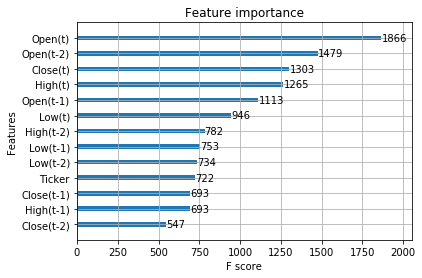

In [92]:
xgboost.plot_importance(xgb, height=0.3)